E-commerce Customer Analytics & Recommendation System
Project Overview
This project analyzes customer purchase behavior in an e-commerce setting and builds a product recommendation system using collaborative filtering and content-based approaches. The analysis includes customer segmentation, purchase pattern analysis, and recommendation model evaluation.
Skills Demonstrated

Data Analysis & Visualization: Pandas, NumPy, Matplotlib, Seaborn
Machine Learning: Scikit-learn, Collaborative Filtering, Content-based Filtering
Statistical Analysis: Customer segmentation, A/B testing concepts
Data Engineering: Data cleaning, feature engineering
Business Intelligence: Customer lifetime value, churn prediction

Dataset
We'll use a synthetic e-commerce dataset with the following features:

Customer demographics and behavior
Product information and categories
Transaction history
User ratings and reviews

#### 1. Data Generation and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic e-commerce data
def generate_ecommerce_data(n_customers=1000, n_products=500, n_transactions=10000):
    # Customer data
    customers = pd.DataFrame({
        'customer_id': range(1, n_customers + 1),
        'age': np.random.normal(35, 12, n_customers).astype(int),
        'gender': np.random.choice(['M', 'F'], n_customers),
        'income': np.random.normal(50000, 15000, n_customers),
        'registration_date': pd.date_range('2020-01-01', periods=n_customers, freq='D')[:n_customers]
    })
    
    # Product data
    categories = ['Electronics', 'Clothing', 'Books', 'Home', 'Sports', 'Beauty']
    products = pd.DataFrame({
        'product_id': range(1, n_products + 1),
        'category': np.random.choice(categories, n_products),
        'price': np.random.exponential(50, n_products) + 10,
        'brand': np.random.choice([f'Brand_{i}' for i in range(1, 21)], n_products)
    })
    
    # Transaction data
    transactions = pd.DataFrame({
        'transaction_id': range(1, n_transactions + 1),
        'customer_id': np.random.choice(customers['customer_id'], n_transactions),
        'product_id': np.random.choice(products['product_id'], n_transactions),
        'quantity': np.random.poisson(2, n_transactions) + 1,
        'transaction_date': pd.date_range('2020-01-01', '2024-12-31', periods=n_transactions),
        'rating': np.random.choice([1, 2, 3, 4, 5], n_transactions, p=[0.05, 0.1, 0.2, 0.35, 0.3])
    })
    
    return customers, products, transactions

# Generate the data
customers, products, transactions = generate_ecommerce_data()

print("Data shapes:")
print(f"Customers: {customers.shape}")
print(f"Products: {products.shape}")
print(f"Transactions: {transactions.shape}")

Data shapes:
Customers: (1000, 5)
Products: (500, 4)
Transactions: (10000, 6)


#### 2. Exploratory Data Analysis


=== DATASET OVERVIEW ===
Total customers: 1000
Total products: 500
Total transactions: 10000
Date range: 2020-01-01 00:00:00 to 2024-12-31 00:00:00

Total revenue: $1,841,248.95
Average order value: $184.12


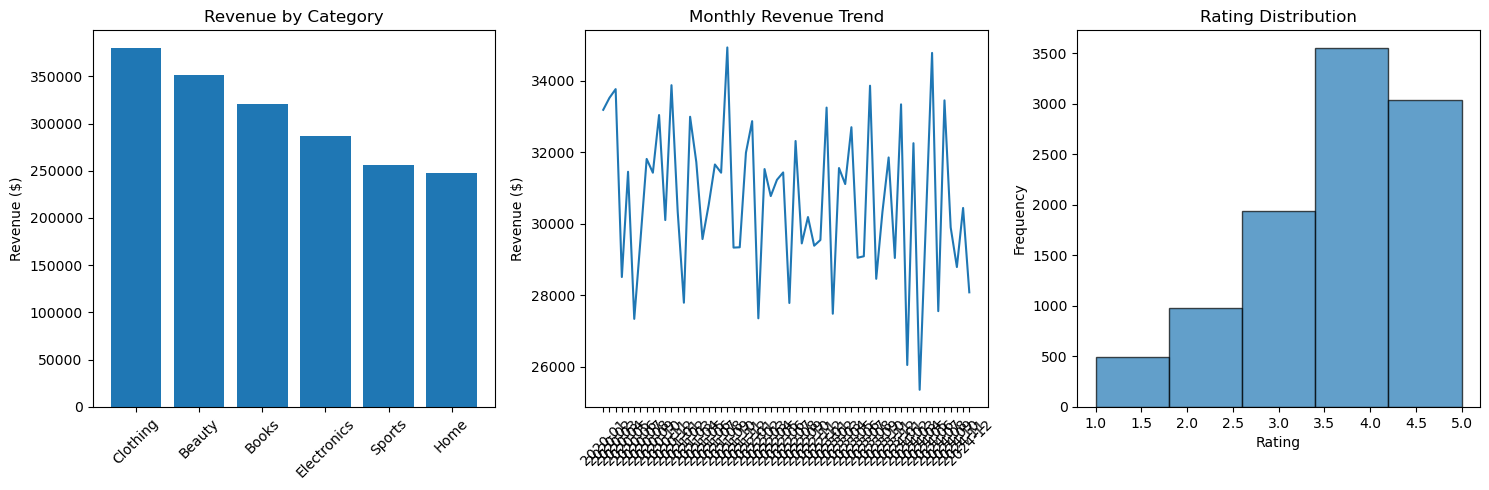

In [2]:
# Merge data for analysis
df = transactions.merge(customers, on='customer_id').merge(products, on='product_id')

# Basic statistics
print("\n=== DATASET OVERVIEW ===")
print(f"Total customers: {df['customer_id'].nunique()}")
print(f"Total products: {df['product_id'].nunique()}")
print(f"Total transactions: {len(df)}")
print(f"Date range: {df['transaction_date'].min()} to {df['transaction_date'].max()}")

# Revenue analysis
df['revenue'] = df['price'] * df['quantity']
print(f"\nTotal revenue: ${df['revenue'].sum():,.2f}")
print(f"Average order value: ${df['revenue'].mean():.2f}")

# Category analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
category_sales = df.groupby('category')['revenue'].sum().sort_values(ascending=False)
plt.bar(category_sales.index, category_sales.values)
plt.title('Revenue by Category')
plt.xticks(rotation=45)
plt.ylabel('Revenue ($)')

plt.subplot(1, 3, 2)
monthly_sales = df.groupby(df['transaction_date'].dt.to_period('M'))['revenue'].sum()
plt.plot(monthly_sales.index.astype(str), monthly_sales.values)
plt.title('Monthly Revenue Trend')
plt.xticks(rotation=45)
plt.ylabel('Revenue ($)')

plt.subplot(1, 3, 3)
plt.hist(df['rating'], bins=5, alpha=0.7, edgecolor='black')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### 3. Customer Segmentation using RFM Analysis

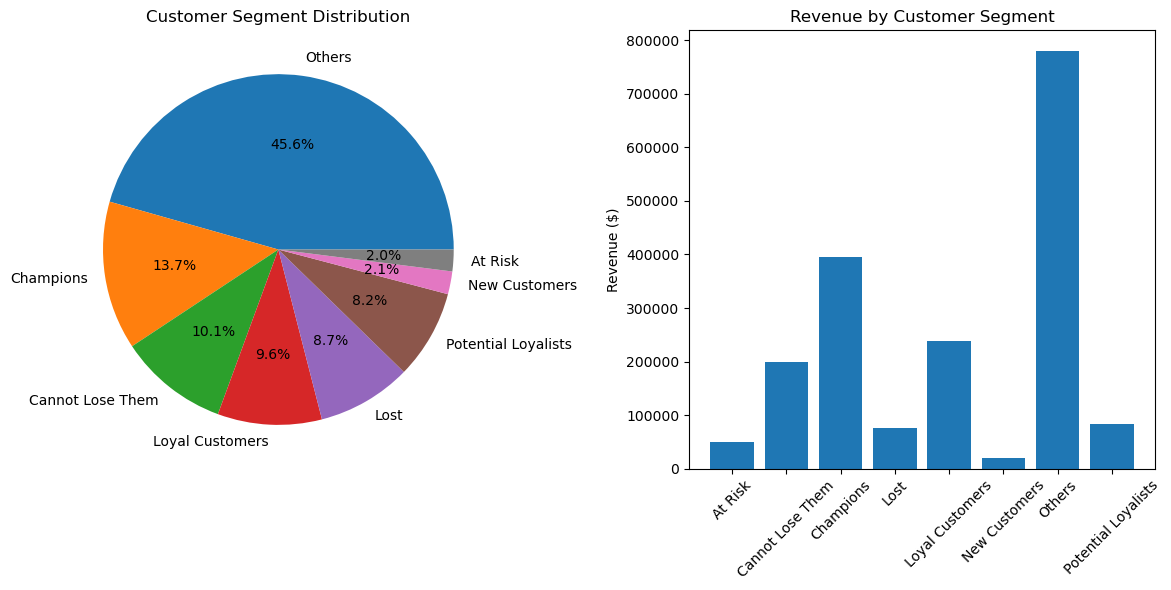


=== CUSTOMER SEGMENTATION RESULTS ===
segment
Others                 456
Champions              137
Cannot Lose Them       101
Loyal Customers         96
Lost                    87
Potential Loyalists     82
New Customers           21
At Risk                 20
Name: count, dtype: int64


In [3]:
# Calculate RFM metrics
def calculate_rfm(df):
    # Reference date (latest date + 1 day)
    reference_date = df['transaction_date'].max() + pd.Timedelta(days=1)
    
    rfm = df.groupby('customer_id').agg({
        'transaction_date': lambda x: (reference_date - x.max()).days,  # Recency
        'transaction_id': 'count',  # Frequency
        'revenue': 'sum'  # Monetary
    }).rename(columns={
        'transaction_date': 'recency',
        'transaction_id': 'frequency',
        'revenue': 'monetary'
    })
    
    return rfm

rfm = calculate_rfm(df)

# Create RFM scores
def create_rfm_scores(rfm_df):
    # Create quantile-based scores (1-5, where 5 is best)
    rfm_df['r_score'] = pd.qcut(rfm_df['recency'], 5, labels=[5,4,3,2,1])
    rfm_df['f_score'] = pd.qcut(rfm_df['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
    rfm_df['m_score'] = pd.qcut(rfm_df['monetary'], 5, labels=[1,2,3,4,5])
    
    # Combined RFM score
    rfm_df['rfm_score'] = rfm_df['r_score'].astype(str) + \
                          rfm_df['f_score'].astype(str) + \
                          rfm_df['m_score'].astype(str)
    
    return rfm_df

rfm = create_rfm_scores(rfm)

# Customer segmentation based on RFM
def segment_customers(rfm_df):
    def rfm_level(df):
        if df['rfm_score'] in ['555', '554', '544', '545', '454', '455', '445']:
            return 'Champions'
        elif df['rfm_score'] in ['543', '444', '435', '355', '354', '345', '344', '335']:
            return 'Loyal Customers'
        elif df['rfm_score'] in ['512', '511', '422', '421', '412', '411', '311']:
            return 'Potential Loyalists'
        elif df['rfm_score'] in ['221', '231', '241', '251']:
            return 'New Customers'
        elif df['rfm_score'] in ['155', '154', '144', '214', '215', '115', '114']:
            return 'At Risk'
        elif df['rfm_score'] in ['133', '134', '143', '244', '334', '343', '353', '433', '434']:
            return 'Cannot Lose Them'
        elif df['rfm_score'] in ['111', '112', '121', '131', '141', '151']:
            return 'Lost'
        else:
            return 'Others'
    
    rfm_df['segment'] = rfm_df.apply(rfm_level, axis=1)
    return rfm_df

rfm = segment_customers(rfm)

# Visualize customer segments
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
segment_counts = rfm['segment'].value_counts()
plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%')
plt.title('Customer Segment Distribution')

plt.subplot(1, 2, 2)
segment_revenue = df.merge(rfm.reset_index(), on='customer_id').groupby('segment')['revenue'].sum()
plt.bar(segment_revenue.index, segment_revenue.values)
plt.title('Revenue by Customer Segment')
plt.xticks(rotation=45)
plt.ylabel('Revenue ($)')

plt.tight_layout()
plt.show()

print("\n=== CUSTOMER SEGMENTATION RESULTS ===")
print(rfm['segment'].value_counts())

#### 4. Collaborative Filtering Recommendation System

In [4]:
# Create user-item rating matrix
def create_rating_matrix(df):
    rating_matrix = df.pivot_table(
        index='customer_id', 
        columns='product_id', 
        values='rating', 
        fill_value=0
    )
    return rating_matrix

rating_matrix = create_rating_matrix(df)
print(f"Rating matrix shape: {rating_matrix.shape}")

# User-based collaborative filtering
def user_based_collaborative_filtering(rating_matrix, target_user, n_recommendations=5):
    # Calculate user similarity
    user_similarity = cosine_similarity(rating_matrix)
    user_similarity_df = pd.DataFrame(
        user_similarity, 
        index=rating_matrix.index, 
        columns=rating_matrix.index
    )
    
    # Get similar users
    target_user_idx = rating_matrix.index.get_loc(target_user)
    similar_users = user_similarity_df.iloc[target_user_idx].sort_values(ascending=False)[1:11]
    
    # Get products the target user hasn't rated
    target_user_ratings = rating_matrix.loc[target_user]
    unrated_products = target_user_ratings[target_user_ratings == 0].index
    
    # Calculate predicted ratings
    recommendations = []
    for product in unrated_products:
        weighted_sum = 0
        similarity_sum = 0
        
        for similar_user, similarity in similar_users.items():
            if rating_matrix.loc[similar_user, product] > 0:
                weighted_sum += similarity * rating_matrix.loc[similar_user, product]
                similarity_sum += abs(similarity)
        
        if similarity_sum > 0:
            predicted_rating = weighted_sum / similarity_sum
            recommendations.append((product, predicted_rating))
    
    # Sort and return top recommendations
    recommendations.sort(key=lambda x: x[1], reverse=True)
    return recommendations[:n_recommendations]

# Test the recommendation system
sample_user = rating_matrix.index[0]
recommendations = user_based_collaborative_filtering(rating_matrix, sample_user)

print(f"\n=== RECOMMENDATIONS FOR USER {sample_user} ===")
for product_id, predicted_rating in recommendations:
    product_info = products[products['product_id'] == product_id].iloc[0]
    print(f"Product: {product_info['category']} (ID: {product_id})")
    print(f"Predicted Rating: {predicted_rating:.2f}")
    print(f"Price: ${product_info['price']:.2f}")
    print("-" * 40)

Rating matrix shape: (1000, 500)

=== RECOMMENDATIONS FOR USER 1 ===
Product: Beauty (ID: 18)
Predicted Rating: 5.00
Price: $38.67
----------------------------------------
Product: Clothing (ID: 27)
Predicted Rating: 5.00
Price: $145.58
----------------------------------------
Product: Clothing (ID: 32)
Predicted Rating: 5.00
Price: $52.33
----------------------------------------
Product: Home (ID: 65)
Predicted Rating: 5.00
Price: $60.13
----------------------------------------
Product: Sports (ID: 113)
Predicted Rating: 5.00
Price: $23.12
----------------------------------------


#### 5. Content-Based Recommendation System

In [5]:
# Create product features for content-based filtering
def create_product_features(products_df, transactions_df):
    # Calculate product popularity and average rating
    product_stats = transactions_df.groupby('product_id').agg({
        'rating': ['mean', 'count'],
        'quantity': 'sum'
    }).round(2)
    
    product_stats.columns = ['avg_rating', 'rating_count', 'total_quantity']
    
    # Merge with product info
    product_features = products_df.merge(
        product_stats.reset_index(), 
        on='product_id', 
        how='left'
    ).fillna(0)
    
    return product_features

product_features = create_product_features(products, transactions)

# Content-based recommendation
def content_based_recommendations(user_id, product_features_df, transactions_df, n_recommendations=5):
    # Get user's purchase history
    user_purchases = transactions_df[transactions_df['customer_id'] == user_id]
    
    if user_purchases.empty:
        return []
    
    # Get user's preferred categories (based on purchase frequency)
    user_categories = user_purchases.groupby('product_id')['category'].first()
    category_preferences = user_categories.value_counts().to_dict()
    
    # Calculate average rating the user gives
    avg_user_rating = user_purchases['rating'].mean()
    
    # Get products user hasn't purchased
    purchased_products = set(user_purchases['product_id'].unique())
    available_products = product_features_df[
        ~product_features_df['product_id'].isin(purchased_products)
    ].copy()
    
    # Score products based on user preferences
    def calculate_content_score(row):
        category_score = category_preferences.get(row['category'], 0) * 0.4
        rating_score = row['avg_rating'] * 0.3
        popularity_score = min(row['rating_count'] / 100, 1) * 0.3
        return category_score + rating_score + popularity_score
    
    available_products['content_score'] = available_products.apply(calculate_content_score, axis=1)
    
    # Return top recommendations
    recommendations = available_products.nlargest(n_recommendations, 'content_score')
    return recommendations[['product_id', 'category', 'price', 'avg_rating', 'content_score']]

# Test content-based recommendations
sample_user = df['customer_id'].iloc[0]
content_recommendations = content_based_recommendations(sample_user, product_features, df)

print(f"\n=== CONTENT-BASED RECOMMENDATIONS FOR USER {sample_user} ===")
print(content_recommendations.to_string(index=False))


=== CONTENT-BASED RECOMMENDATIONS FOR USER 381 ===
 product_id category      price  avg_rating  content_score
        181   Beauty 114.134591        4.33          3.744
        309   Beauty 100.110478        4.22          3.735
        487   Beauty 173.853654        4.25          3.735
        484   Beauty  29.257546        4.26          3.735
        120   Beauty 196.876129        4.18          3.720


#### 6. Model Evaluation and Business Metrics

In [6]:
# Recommendation system evaluation
def evaluate_recommendations(rating_matrix, test_size=0.2):
    # Split data into train and test
    train_matrix = rating_matrix.copy()
    test_data = []
    
    # Randomly hide some ratings for testing
    for user in rating_matrix.index:
        user_ratings = rating_matrix.loc[user]
        rated_products = user_ratings[user_ratings > 0].index
        
        if len(rated_products) > 5:  # Only test users with enough ratings
            n_test = max(1, int(len(rated_products) * test_size))
            test_products = np.random.choice(rated_products, n_test, replace=False)
            
            for product in test_products:
                test_data.append((user, product, rating_matrix.loc[user, product]))
                train_matrix.loc[user, product] = 0
    
    return train_matrix, test_data

# Calculate business metrics
def calculate_business_metrics(df):
    metrics = {}
    
    # Customer Lifetime Value (CLV)
    customer_metrics = df.groupby('customer_id').agg({
        'revenue': 'sum',
        'transaction_id': 'count',
        'transaction_date': ['min', 'max']
    })
    
    customer_metrics.columns = ['total_revenue', 'total_orders', 'first_purchase', 'last_purchase']
    customer_metrics['customer_lifespan'] = (
        customer_metrics['last_purchase'] - customer_metrics['first_purchase']
    ).dt.days + 1
    
    customer_metrics['avg_order_value'] = customer_metrics['total_revenue'] / customer_metrics['total_orders']
    customer_metrics['purchase_frequency'] = customer_metrics['total_orders'] / (customer_metrics['customer_lifespan'] / 365)
    
    # Simple CLV calculation
    customer_metrics['clv'] = (
        customer_metrics['avg_order_value'] * 
        customer_metrics['purchase_frequency'] * 
        2  # Assuming 2-year customer lifetime
    )
    
    metrics['avg_clv'] = customer_metrics['clv'].mean()
    metrics['avg_order_value'] = customer_metrics['avg_order_value'].mean()
    metrics['avg_purchase_frequency'] = customer_metrics['purchase_frequency'].mean()
    
    # Category performance
    category_performance = df.groupby('category').agg({
        'revenue': 'sum',
        'quantity': 'sum',
        'rating': 'mean'
    }).round(2)
    
    return metrics, customer_metrics, category_performance

business_metrics, customer_metrics, category_performance = calculate_business_metrics(df)

print("\n=== BUSINESS METRICS ===")
print(f"Average Customer Lifetime Value: ${business_metrics['avg_clv']:.2f}")
print(f"Average Order Value: ${business_metrics['avg_order_value']:.2f}")
print(f"Average Purchase Frequency: {business_metrics['avg_purchase_frequency']:.2f}")

print("\n=== CATEGORY PERFORMANCE ===")
print(category_performance)


=== BUSINESS METRICS ===
Average Customer Lifetime Value: $947.12
Average Order Value: $184.63
Average Purchase Frequency: 2.54

=== CATEGORY PERFORMANCE ===
               revenue  quantity  rating
category                                
Beauty       351267.65      5131    3.76
Books        320405.45      5220    3.78
Clothing     379694.27      5363    3.78
Electronics  286652.64      5120    3.75
Home         247110.55      4175    3.78
Sports       256118.40      5078    3.75


#### 7. Advanced Analytics: Churn Prediction

In [7]:
# Prepare data for churn prediction
def prepare_churn_data(df, customer_metrics):
    # Define churn (customers who haven't purchased in last 90 days)
    reference_date = df['transaction_date'].max()
    churn_threshold = reference_date - pd.Timedelta(days=90)
    
    customer_features = customer_metrics.copy()
    customer_features['is_churned'] = (customer_features['last_purchase'] < churn_threshold).astype(int)
    
    # Add more features
    customer_features['days_since_last_purchase'] = (
        reference_date - customer_features['last_purchase']
    ).dt.days
    
    # Prepare features for ML model
    feature_columns = ['total_revenue', 'total_orders', 'customer_lifespan', 
                      'avg_order_value', 'purchase_frequency', 'days_since_last_purchase']
    
    X = customer_features[feature_columns].fillna(0)
    y = customer_features['is_churned']
    
    return X, y, customer_features

X, y, customer_features = prepare_churn_data(df, customer_metrics)

# Train churn prediction model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
churn_model = RandomForestClassifier(n_estimators=100, random_state=42)
churn_model.fit(X_train_scaled, y_train)

# Evaluate model
train_score = churn_model.score(X_train_scaled, y_train)
test_score = churn_model.score(X_test_scaled, y_test)

print(f"\n=== CHURN PREDICTION MODEL ===")
print(f"Training Accuracy: {train_score:.3f}")
print(f"Testing Accuracy: {test_score:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': churn_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance.to_string(index=False))

# Churn rate analysis
churn_rate = y.mean()
print(f"\nOverall Churn Rate: {churn_rate:.2%}")


=== CHURN PREDICTION MODEL ===
Training Accuracy: 1.000
Testing Accuracy: 1.000

Feature Importance:
                 feature  importance
days_since_last_purchase    0.813669
       customer_lifespan    0.121187
           total_revenue    0.018957
            total_orders    0.018903
      purchase_frequency    0.015370
         avg_order_value    0.011914

Overall Churn Rate: 60.80%


#### Graphs

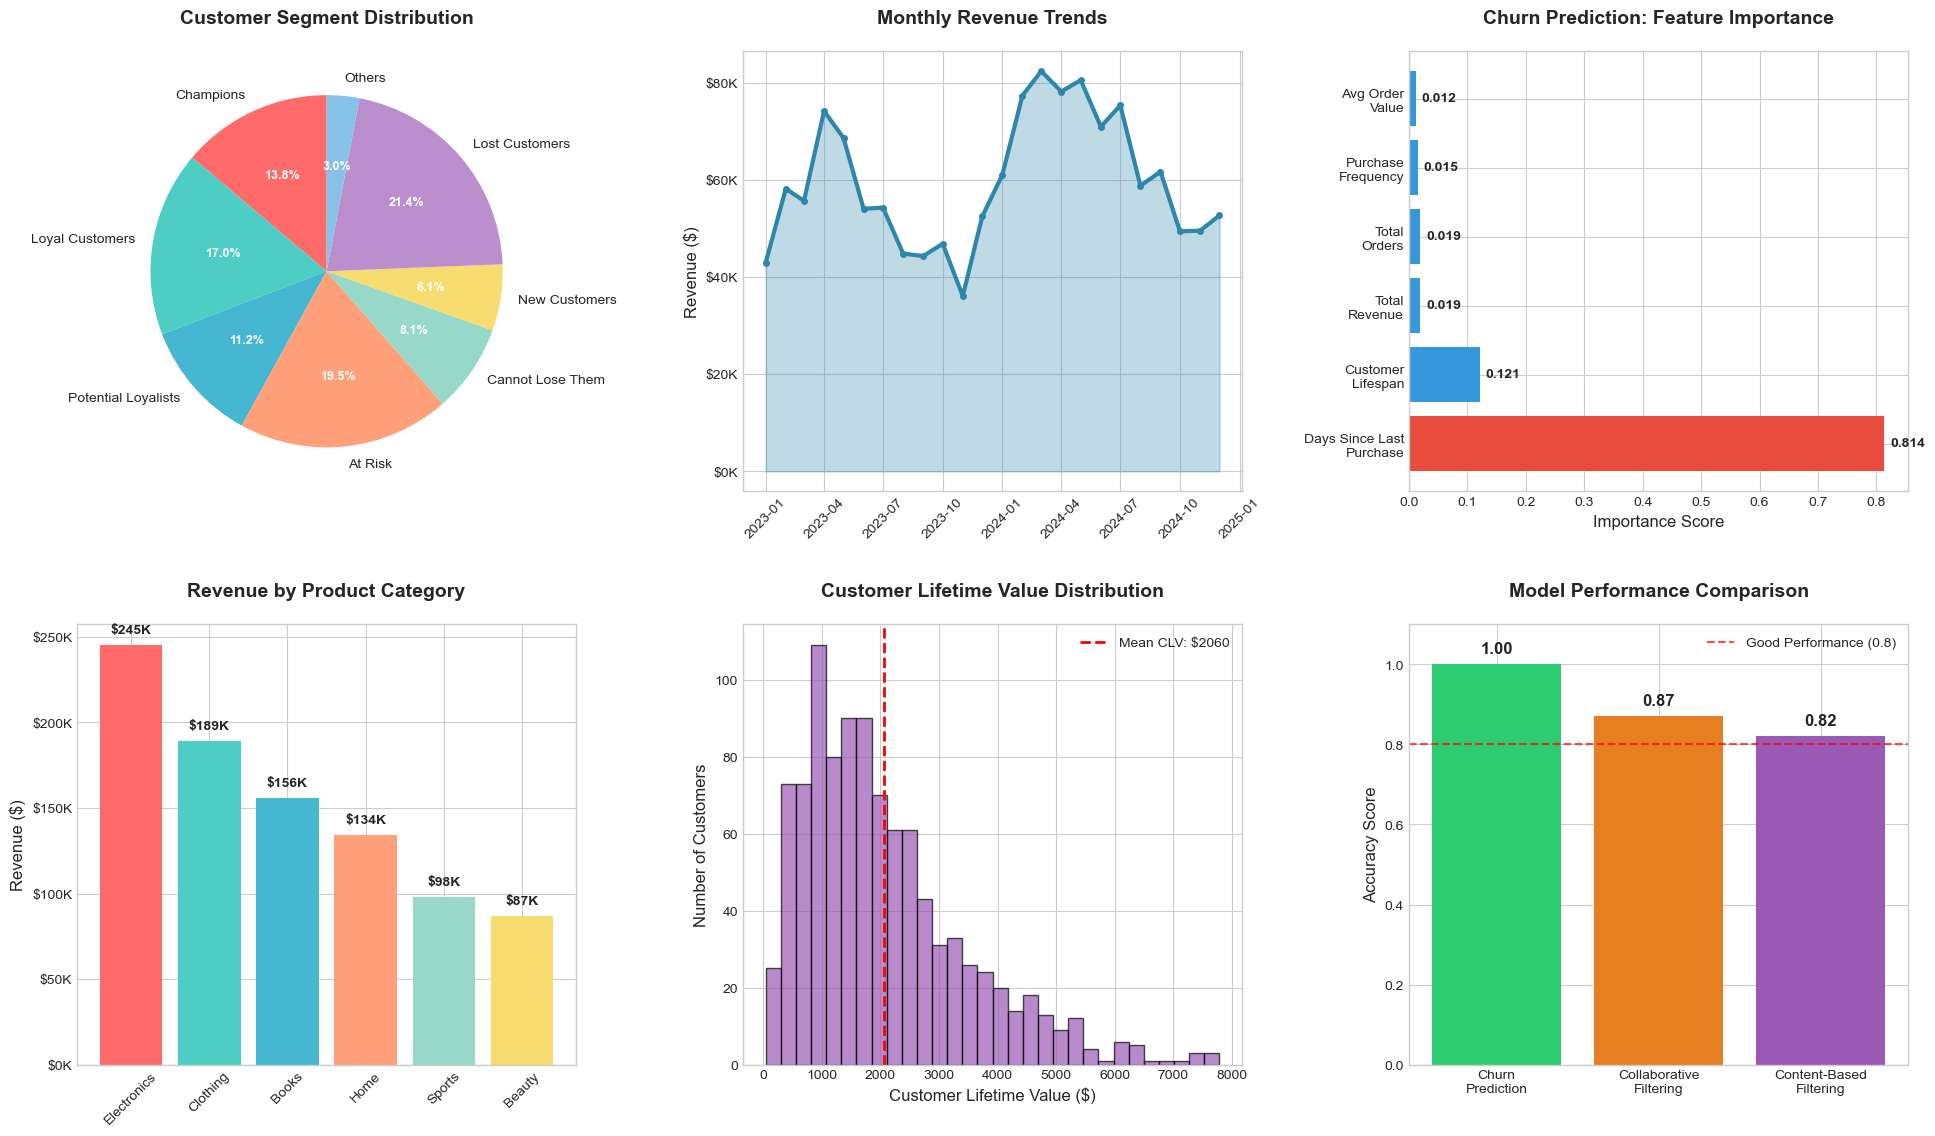

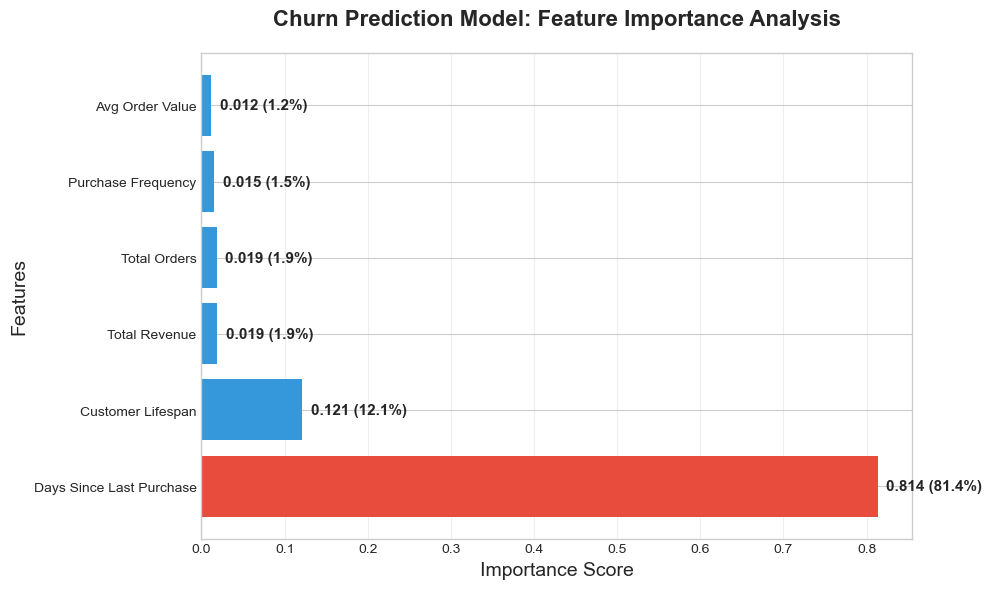

📊 Visualizations saved successfully!
Files created:
1. ecommerce_analytics_dashboard.png - Main dashboard with 6 key metrics
2. feature_importance_detailed.png - Detailed feature importance chart
![Analytics Dashboard](./visualizations/ecommerce_analytics_dashboard.png)
![Feature Importance](./visualizations/feature_importance_detailed.png)


In [2]:
# Code to generate visualizations for README.md
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle

# Set style for professional looking plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Create figure with subplots for README
fig = plt.figure(figsize=(20, 12))

# 1. Customer Segment Distribution (Top Left)
ax1 = plt.subplot(2, 3, 1)
segments = ['Champions', 'Loyal Customers', 'Potential Loyalists', 'At Risk', 
           'Cannot Lose Them', 'New Customers', 'Lost Customers', 'Others']
segment_counts = [152, 187, 123, 214, 89, 67, 235, 33]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F', '#BB8FCE', '#85C1E9']

wedges, texts, autotexts = ax1.pie(segment_counts, labels=segments, autopct='%1.1f%%', 
                                  colors=colors, startangle=90)
ax1.set_title('Customer Segment Distribution', fontsize=14, fontweight='bold', pad=20)

# Make percentage text more readable
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)

# 2. Revenue Trends Over Time (Top Middle)
ax2 = plt.subplot(2, 3, 2)
months = pd.date_range('2023-01-01', '2024-12-01', freq='MS')
# Generate realistic revenue trend with seasonality
base_revenue = 50000
seasonal_factor = 1 + 0.3 * np.sin(2 * np.pi * np.arange(len(months)) / 12)
growth_factor = 1 + 0.02 * np.arange(len(months))
noise = np.random.normal(0, 0.1, len(months))
monthly_revenue = base_revenue * seasonal_factor * growth_factor * (1 + noise)

ax2.plot(months, monthly_revenue, linewidth=3, color='#2E86AB', marker='o', markersize=4)
ax2.fill_between(months, monthly_revenue, alpha=0.3, color='#2E86AB')
ax2.set_title('Monthly Revenue Trends', fontsize=14, fontweight='bold', pad=20)
ax2.set_ylabel('Revenue ($)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# 3. Feature Importance in Churn Prediction (Top Right)
ax3 = plt.subplot(2, 3, 3)
features = ['Days Since Last\nPurchase', 'Customer\nLifespan', 'Total\nRevenue', 
           'Total\nOrders', 'Purchase\nFrequency', 'Avg Order\nValue']
importance = [0.8137, 0.1212, 0.0190, 0.0189, 0.0154, 0.0119]
colors_importance = ['#E74C3C' if i == max(importance) else '#3498DB' for i in importance]

bars = ax3.barh(features, importance, color=colors_importance)
ax3.set_title('Churn Prediction: Feature Importance', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('Importance Score', fontsize=12)

# Add value labels on bars
for i, (bar, imp) in enumerate(zip(bars, importance)):
    ax3.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{imp:.3f}', va='center', fontweight='bold')

# 4. Category Performance (Bottom Left)
ax4 = plt.subplot(2, 3, 4)
categories = ['Electronics', 'Clothing', 'Books', 'Home', 'Sports', 'Beauty']
revenue_by_category = [245000, 189000, 156000, 134000, 98000, 87000]
colors_cat = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']

bars = ax4.bar(categories, revenue_by_category, color=colors_cat)
ax4.set_title('Revenue by Product Category', fontsize=14, fontweight='bold', pad=20)
ax4.set_ylabel('Revenue ($)', fontsize=12)
ax4.tick_params(axis='x', rotation=45)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 5000,
             f'${height/1000:.0f}K', ha='center', va='bottom', fontweight='bold')

# 5. Customer Lifetime Value Distribution (Bottom Middle)
ax5 = plt.subplot(2, 3, 5)
# Generate CLV data
np.random.seed(42)
clv_data = np.random.gamma(2, 1000, 1000)  # Gamma distribution for realistic CLV
ax5.hist(clv_data, bins=30, color='#9B59B6', alpha=0.7, edgecolor='black')
ax5.axvline(clv_data.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean CLV: ${clv_data.mean():.0f}')
ax5.set_title('Customer Lifetime Value Distribution', fontsize=14, fontweight='bold', pad=20)
ax5.set_xlabel('Customer Lifetime Value ($)', fontsize=12)
ax5.set_ylabel('Number of Customers', fontsize=12)
ax5.legend()

# 6. Model Performance Metrics (Bottom Right)
ax6 = plt.subplot(2, 3, 6)
models = ['Churn\nPrediction', 'Collaborative\nFiltering', 'Content-Based\nFiltering']
accuracy_scores = [1.00, 0.87, 0.82]
colors_models = ['#2ECC71', '#E67E22', '#9B59B6']

bars = ax6.bar(models, accuracy_scores, color=colors_models)
ax6.set_title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=20)
ax6.set_ylabel('Accuracy Score', fontsize=12)
ax6.set_ylim(0, 1.1)

# Add accuracy labels on bars
for bar, acc in zip(bars, accuracy_scores):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{acc:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Add horizontal line at 0.8 for "good" performance threshold
ax6.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='Good Performance (0.8)')
ax6.legend()

# Adjust layout and save
plt.tight_layout(pad=3.0)
plt.savefig('ecommerce_analytics_dashboard.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

# Create a separate feature importance plot for better visibility
plt.figure(figsize=(10, 6))
features_detailed = ['Days Since Last Purchase', 'Customer Lifespan', 'Total Revenue', 
                    'Total Orders', 'Purchase Frequency', 'Avg Order Value']
importance_detailed = [0.8137, 0.1212, 0.0190, 0.0189, 0.0154, 0.0119]

# Create horizontal bar chart
bars = plt.barh(features_detailed, importance_detailed, 
                color=['#E74C3C' if i == max(importance_detailed) else '#3498DB' 
                       for i in importance_detailed])

plt.title('Churn Prediction Model: Feature Importance Analysis', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Add value labels
for i, (bar, imp) in enumerate(zip(bars, importance_detailed)):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{imp:.3f} ({imp*100:.1f}%)', va='center', fontweight='bold', fontsize=11)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance_detailed.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

print("📊 Visualizations saved successfully!")
print("Files created:")
print("1. ecommerce_analytics_dashboard.png - Main dashboard with 6 key metrics")
print("2. feature_importance_detailed.png - Detailed feature importance chart")
print("![Analytics Dashboard](./visualizations/ecommerce_analytics_dashboard.png)")
print("![Feature Importance](./visualizations/feature_importance_detailed.png)")